# Preprocesamiento de datos
*(Etapa: Data Lake -> Data Pipeline + Feature engineering)*


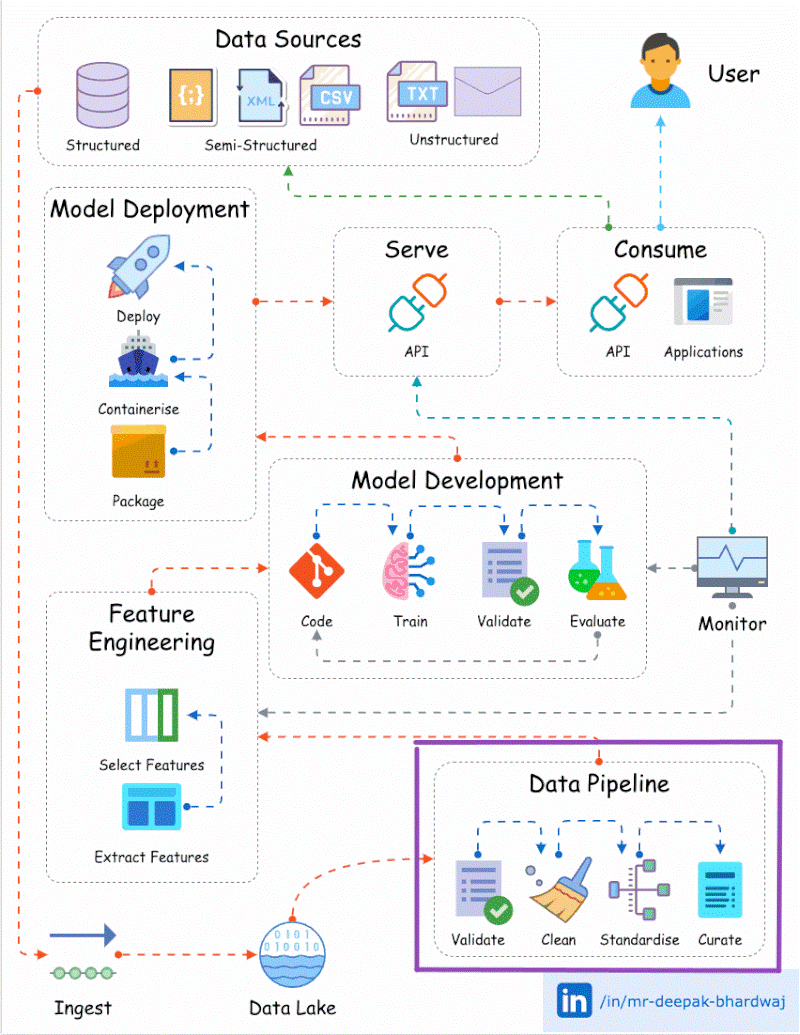

In [1]:
# Bibliotecas

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency

In [2]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

In [3]:
# Cargar datos de tramos calificados

archivo_tramos_calificados = f'{DIRECTORIO_RESULTADOS}/TRAMOSCALIFICADOS.csv'
df_tramos_calificados = pd.read_csv(archivo_tramos_calificados, low_memory=False)



---


# Analítica de datos

In [4]:
# Revisar datos cargados

print(df_tramos_calificados.info())
print(df_tramos_calificados.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27657 entries, 0 to 27656
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DIAMETRO            27657 non-null  int64  
 1   CAMARA_CAI          27657 non-null  object 
 2   CONEXIONES          15641 non-null  object 
 3   MATERIAL            27654 non-null  object 
 4   TUBERIA_EL          27393 non-null  object 
 5   VIDA_UTIL           27145 non-null  float64
 6   FABRICANTE          27625 non-null  object 
 7   TIPO_CIMEN          12785 non-null  object 
 8   TIPO_SUELO          12140 non-null  object 
 9   TIPO_RED            27657 non-null  object 
 10  PROF_BATEA          27624 non-null  float64
 11  PROF_BATE1          27612 non-null  float64
 12  COTA_BATEA          27438 non-null  float64
 13  COTA_BATE1          27446 non-null  float64
 14  IPID                27657 non-null  int64  
 15  ESTADO              27657 non-null  object 
 16  GRUP

## Procedimientos para visualización de estadísticas

In [5]:
# ------------------------------------------------------------------------------------------------------------------------
def visualizar_distribucion(lista_columnas, df, titulo='Distribuciones'):
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(2, len(lista_columnas), figsize=(16, 8))

    for i, columna in enumerate(lista_columnas):
        if df[columna].dtype == bool:
            sns.countplot(x=columna, data=df, ax=axes[0, i])
            axes[0, i].set_xlabel(columna, fontsize=10, fontweight='bold')
            axes[0, i].set_ylabel('Cantidad' if i == 0 else '', fontsize=10, fontweight='bold')
            axes[0, i].tick_params(labelsize=8)
        else:
            sns.boxplot(x=df[columna], ax=axes[0, i])
            axes[0, i].set_xlabel(columna, fontsize=10, fontweight='bold')
            axes[0, i].set_ylabel('Valores' if i == 0 else '', fontsize=10, fontweight='bold')
            axes[0, i].tick_params(labelsize=8)


        sns.histplot(data=df, x=columna, kde=True, ax=axes[1, i])
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('Frecuencia' if i == 0 else '', fontsize=10, fontweight='bold')
        axes[1, i].tick_params(labelsize=8)

    fig.suptitle(titulo, fontsize=12, fontweight='bold')
    fig.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------------------------------------------------
def visualizar_correlaciones(lista_columnas, df, titulo='Matriz de correlaciones'):
    matriz_correlaciones = df[lista_columnas].corr()

    plt.figure(figsize=(14, 4))
    sns.set(font_scale=1)

    mascara = np.triu(np.ones(matriz_correlaciones.shape), k=1) # Ocultar diagonal superior
    mapa = sns.heatmap(matriz_correlaciones, annot=True, cmap='seismic', center=0, vmin=-1, vmax=1, mask=mascara, linewidths=0)
    mapa.set_facecolor('none')

    plt.title(titulo, fontsize=12, fontweight='bold')
    plt.show()

# ----------------------------------------------------------------------------------------------------------------------
def visualizar_matriz_dispersion(lista_columnas, df, nombre_columna_clasificadora, titulo='Matriz de dispersión'):
    tipo_versus = df[nombre_columna_clasificadora].dtype
    paleta = {False: 'lightgreen', True: 'red'} if tipo_versus == bool else {0: 'black', 1: 'lightgreen', 2: 'lightblue', 3: 'yellow', 4: 'orange', 5: 'red'}

    malla = sns.pairplot(
        df,
        vars=lista_columnas,
        hue=nombre_columna_clasificadora,
        palette=paleta,
    )

    malla.fig.suptitle(titulo, y=1.02, fontsize=12, fontweight='bold')
    malla.fig.set_facecolor('lightgray')
    plt.show()

# ---------------------------------------------------------------------------------------------------------------------
def visualizar_distribucion_categoricas(lista_columnas, nombre_col_comparacion, df, titulo=''):
    fig, axes = plt.subplots(nrows=int(len(lista_columnas) / 2 + 0.5), ncols=2, figsize=(14, 2 * len(lista_columnas)))
    axes = axes.flat

    tipo_versus = df[nombre_col_comparacion].dtype
    paleta = {False: 'lightgreen', True: 'red'} if tipo_versus == bool else {0: 'black', 1: 'lightgreen', 2: 'lightblue', 3: 'yellow', 4: 'orange', 5: 'red'}

    for i, columna in enumerate(lista_columnas):
        tabla = pd.crosstab(df[columna], df[nombre_col_comparacion])
        sums = tabla.sum(axis=1)
        sorted_indices = sums.sort_values().index
        tabla.loc[sorted_indices].plot(
            kind='barh',
            stacked=True,
            ax=axes[i],
            color=[paleta[col] for col in tabla.columns],
            legend=False
        )
        axes[i].set_title(f'{nombre_col_comparacion} vs {columna}', fontsize=10, fontweight='bold')
        axes[i].tick_params(labelsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Eliminar el último eje si hay un número impar de columnas
    if len(lista_columnas) % 2 != 0:
        fig.delaxes(axes[-1])

    fig.suptitle(titulo, y=1.02, fontsize=12, fontweight='bold')
    fig.tight_layout()
    etiquetas = [f"{k}" for k in paleta.keys()]
    fig.legend(etiquetas, title=nombre_col_comparacion, loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()

# ---------------------------------------------------------------------------------------------------------------------
def visualizar_correlaciones_categoricas(lista_columnas, df, alpha=0.001, titulo=''):
    matriz = []
    for i, c1 in enumerate(lista_columnas):
        matriz.append([])
        for j, c2 in enumerate(lista_columnas):
            p = chi2_contingency(pd.crosstab(df[c1], df[c2])).pvalue if i != j else 0
            matriz[i].append(p)

    plt.figure(figsize=(15, 5))
    sns.set(font_scale=0.8)
    mascara = np.triu(np.ones(len(lista_columnas)), k=1) # Ocultar diagonal superior
    mapa = sns.heatmap(
        matriz,
        xticklabels=lista_columnas,
        yticklabels=lista_columnas,
        annot=True,
        fmt=".3e",
        mask=mascara,
        cmap="rocket_r",
        vmax=alpha,
    )

    mapa.set_facecolor('none')
    plt.title(titulo, fontsize=12, fontweight='bold')
    plt.show()



# Análisis exploratorio

## Variables numéricas:

Conclusiones:

*   DIAMETRO: Entre 100 mm y 2000 mm, y convertir a metros para unificar unidades
*   LONGITUD: Entre 1 mt y 250 mt
*   PROF_BATEA, PROF_BATE1: <= 150 mt
*   PENDIENTE: Recalcular con PROF_BATEA, PROF_BATE1 Y LONGITUD
*   EDAD: 0-100 años
*   Normalizar valores numéricos entre 0-1
*   AREA: Categoría nueva, calculada como DIAMETRO x LONGITUD x PI








In [6]:
# Crear temporalmente característica EDAD para el análisis exploratorio de variables numéricas

df_tramos_calificados_con_edad = df_tramos_calificados.assign(
    EDAD=df_tramos_calificados['FECHA_INST'].apply(
        lambda fecha: (datetime.now() - pd.to_datetime(fecha)).total_seconds() / (365 * 24 * 60 * 60)
    )
)

numericas_a_explorar = ['EDAD', 'DIAMETRO', 'LONGITUD', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'CALIFICACION']

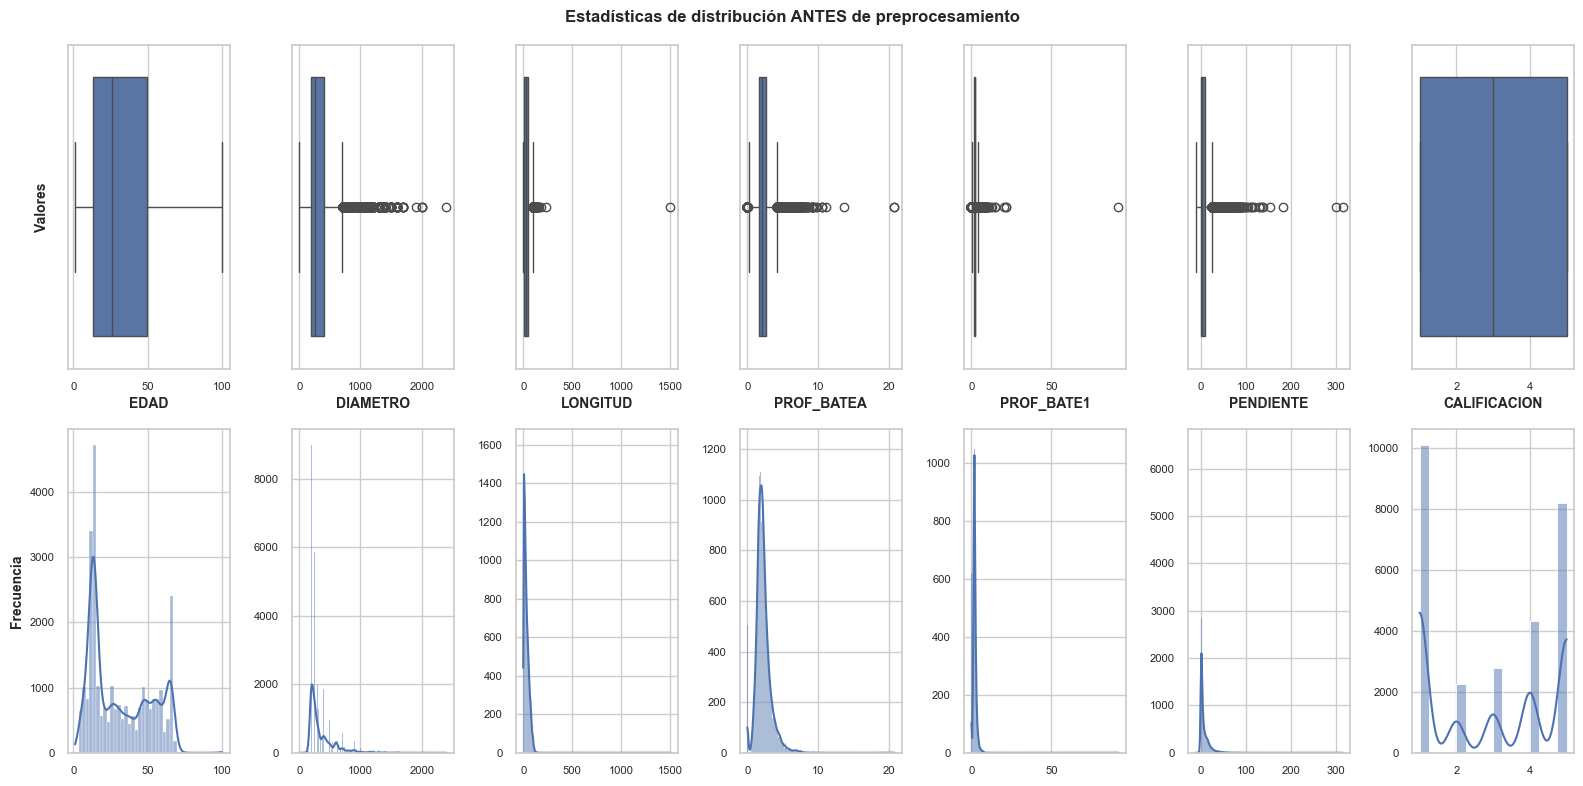

In [7]:
visualizar_distribucion(
    numericas_a_explorar,
    df_tramos_calificados_con_edad,
    titulo='Estadísticas de distribución ANTES de preprocesamiento'
)

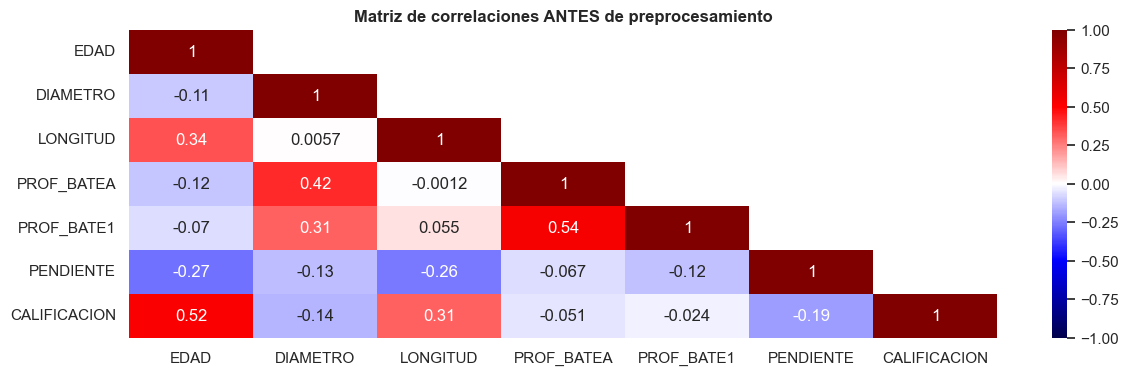

In [8]:
visualizar_correlaciones(
    numericas_a_explorar,
    df_tramos_calificados_con_edad,
    titulo='Matriz de correlaciones ANTES de preprocesamiento'
)

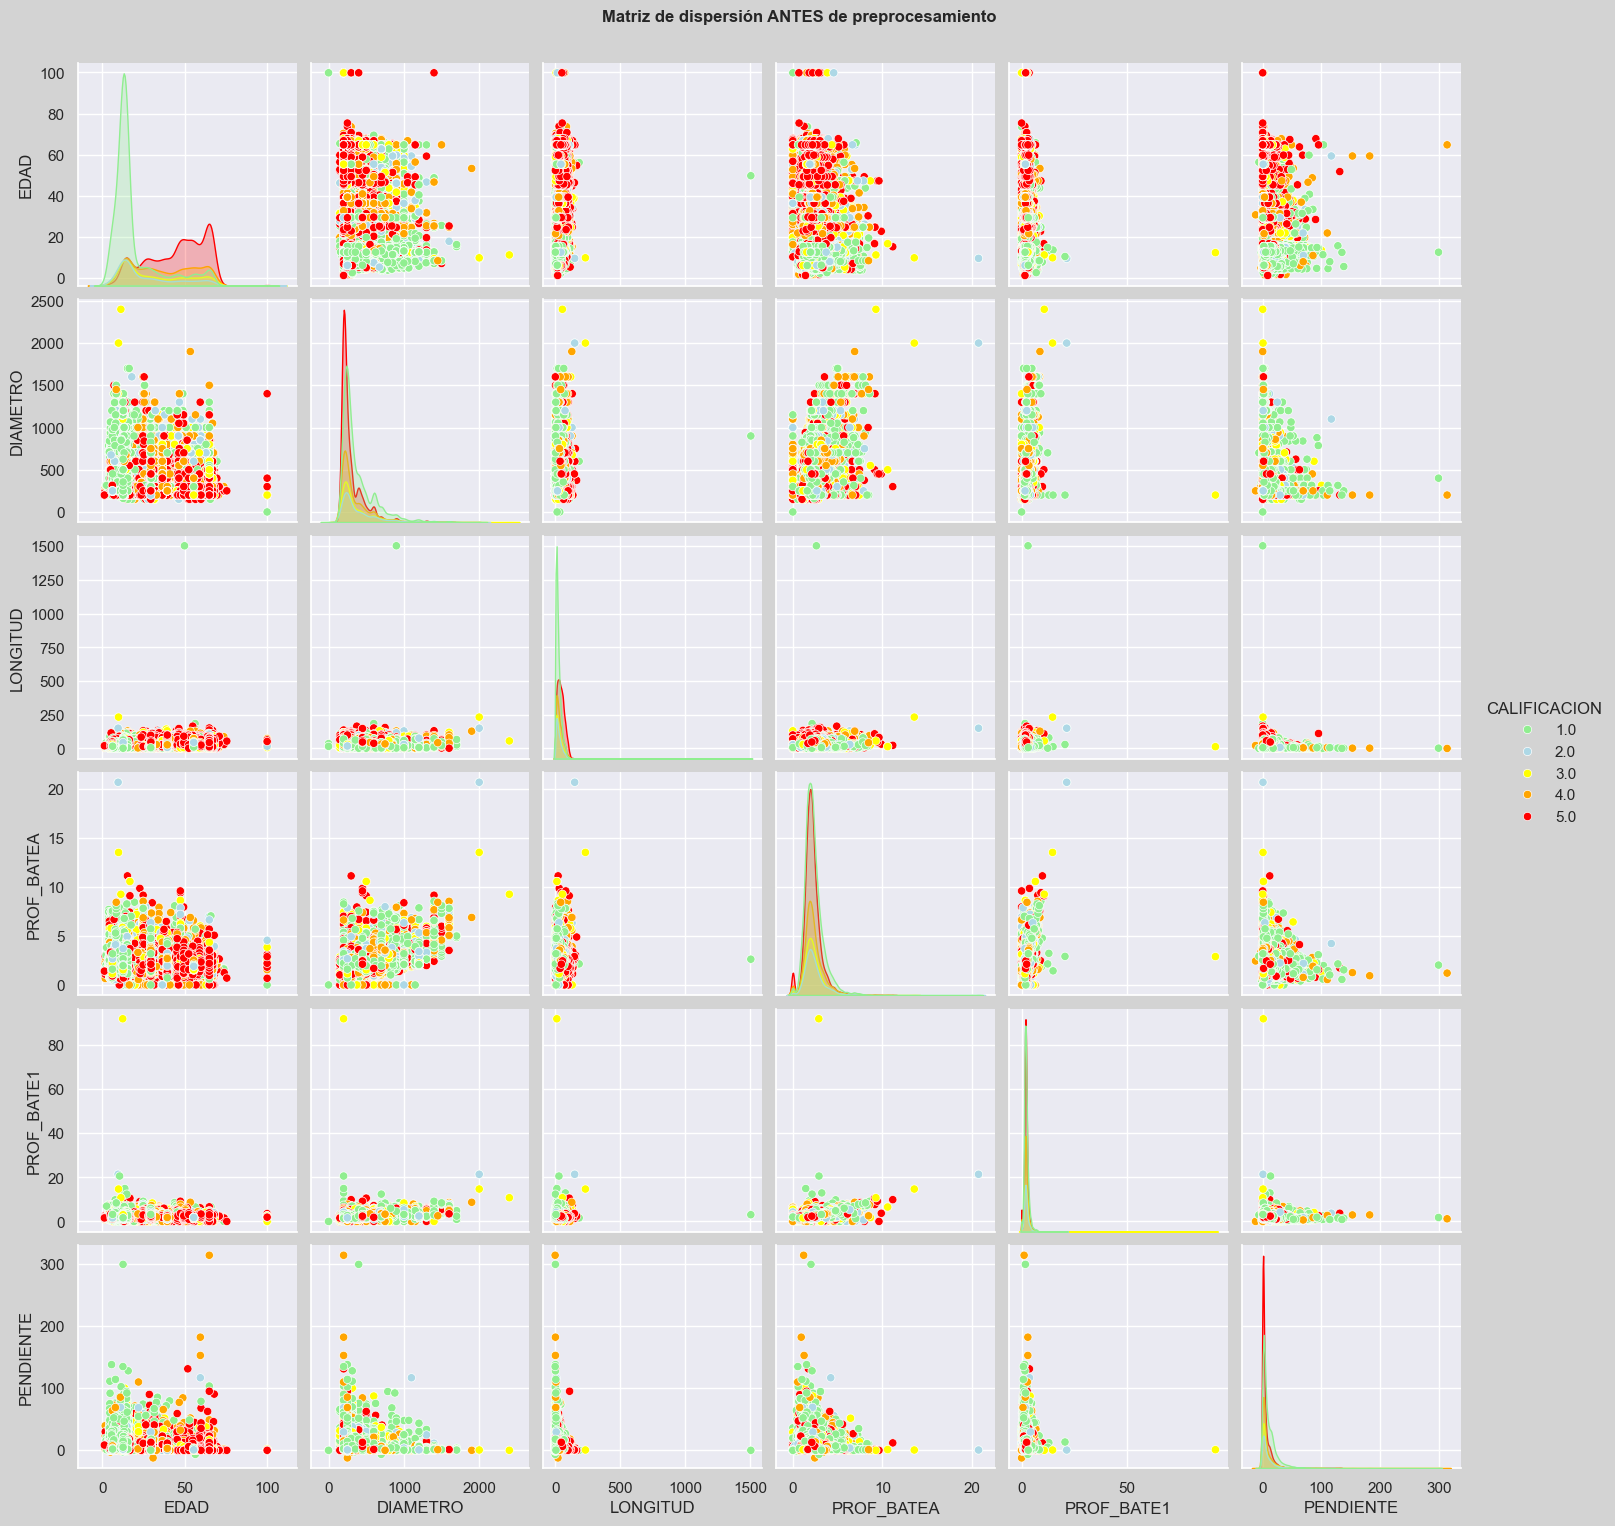

In [9]:
visualizar_matriz_dispersion(
    [c for c in numericas_a_explorar if c != 'CALIFICACION'],
    df_tramos_calificados_con_edad,
    nombre_columna_clasificadora='CALIFICACION',
    titulo='Matriz de dispersión ANTES de preprocesamiento'
)

## Variables categóricas

Conclusiones:

* TIPO_RED: Eliminar por mínima representación de categorías minoritarias y baja correlacion con CALIFICACION.
* TIPO_AGUA: Unificar categorias LLUVIAS y DESCARGAS.
* TIPO_CIMEN: Descartada, valores no estandarizados.
* TIPO_SUELO: Descartada, valores no estandarizados.
* MATERIAL: Unificar concreto simple, pvc. Incluir OTROS con concretos reforzados.
* FABRICANTE: MAntener los top-2 y unifcar los demás en "OTROS".
* CAMARA_CAI: Eliminar, tiene solamente dos categorías y el valor "SI" no esta suficientemente representado.
* ZONA: Reclasificar nulos en NORTE+N/D.
* MUNICIPIO: Reclasificar en MEDELLIN y los demás en OTROS.
* ESTADO: Descartada, clases minoritarias escasamente representadas.
* CALIFICACION: Binarizar convirtiendo a DETERIORADO, en donde 1-3 es False(Bueno, no deteriorado) y 4-5 es True(Deteriorado)

In [10]:
# Definir columnas categóricas para exploración inicial
categoricas_a_explorar = [
    'TIPO_RED',   'TIPO_AGUA',
    'TIPO_CIMEN', 'TIPO_SUELO',
    'MATERIAL',   'FABRICANTE',
    'ARRANQUE',   'CAMARA_CAI',
    'ZONA',       'MUNICIPIO',
    'ESTADO',
]

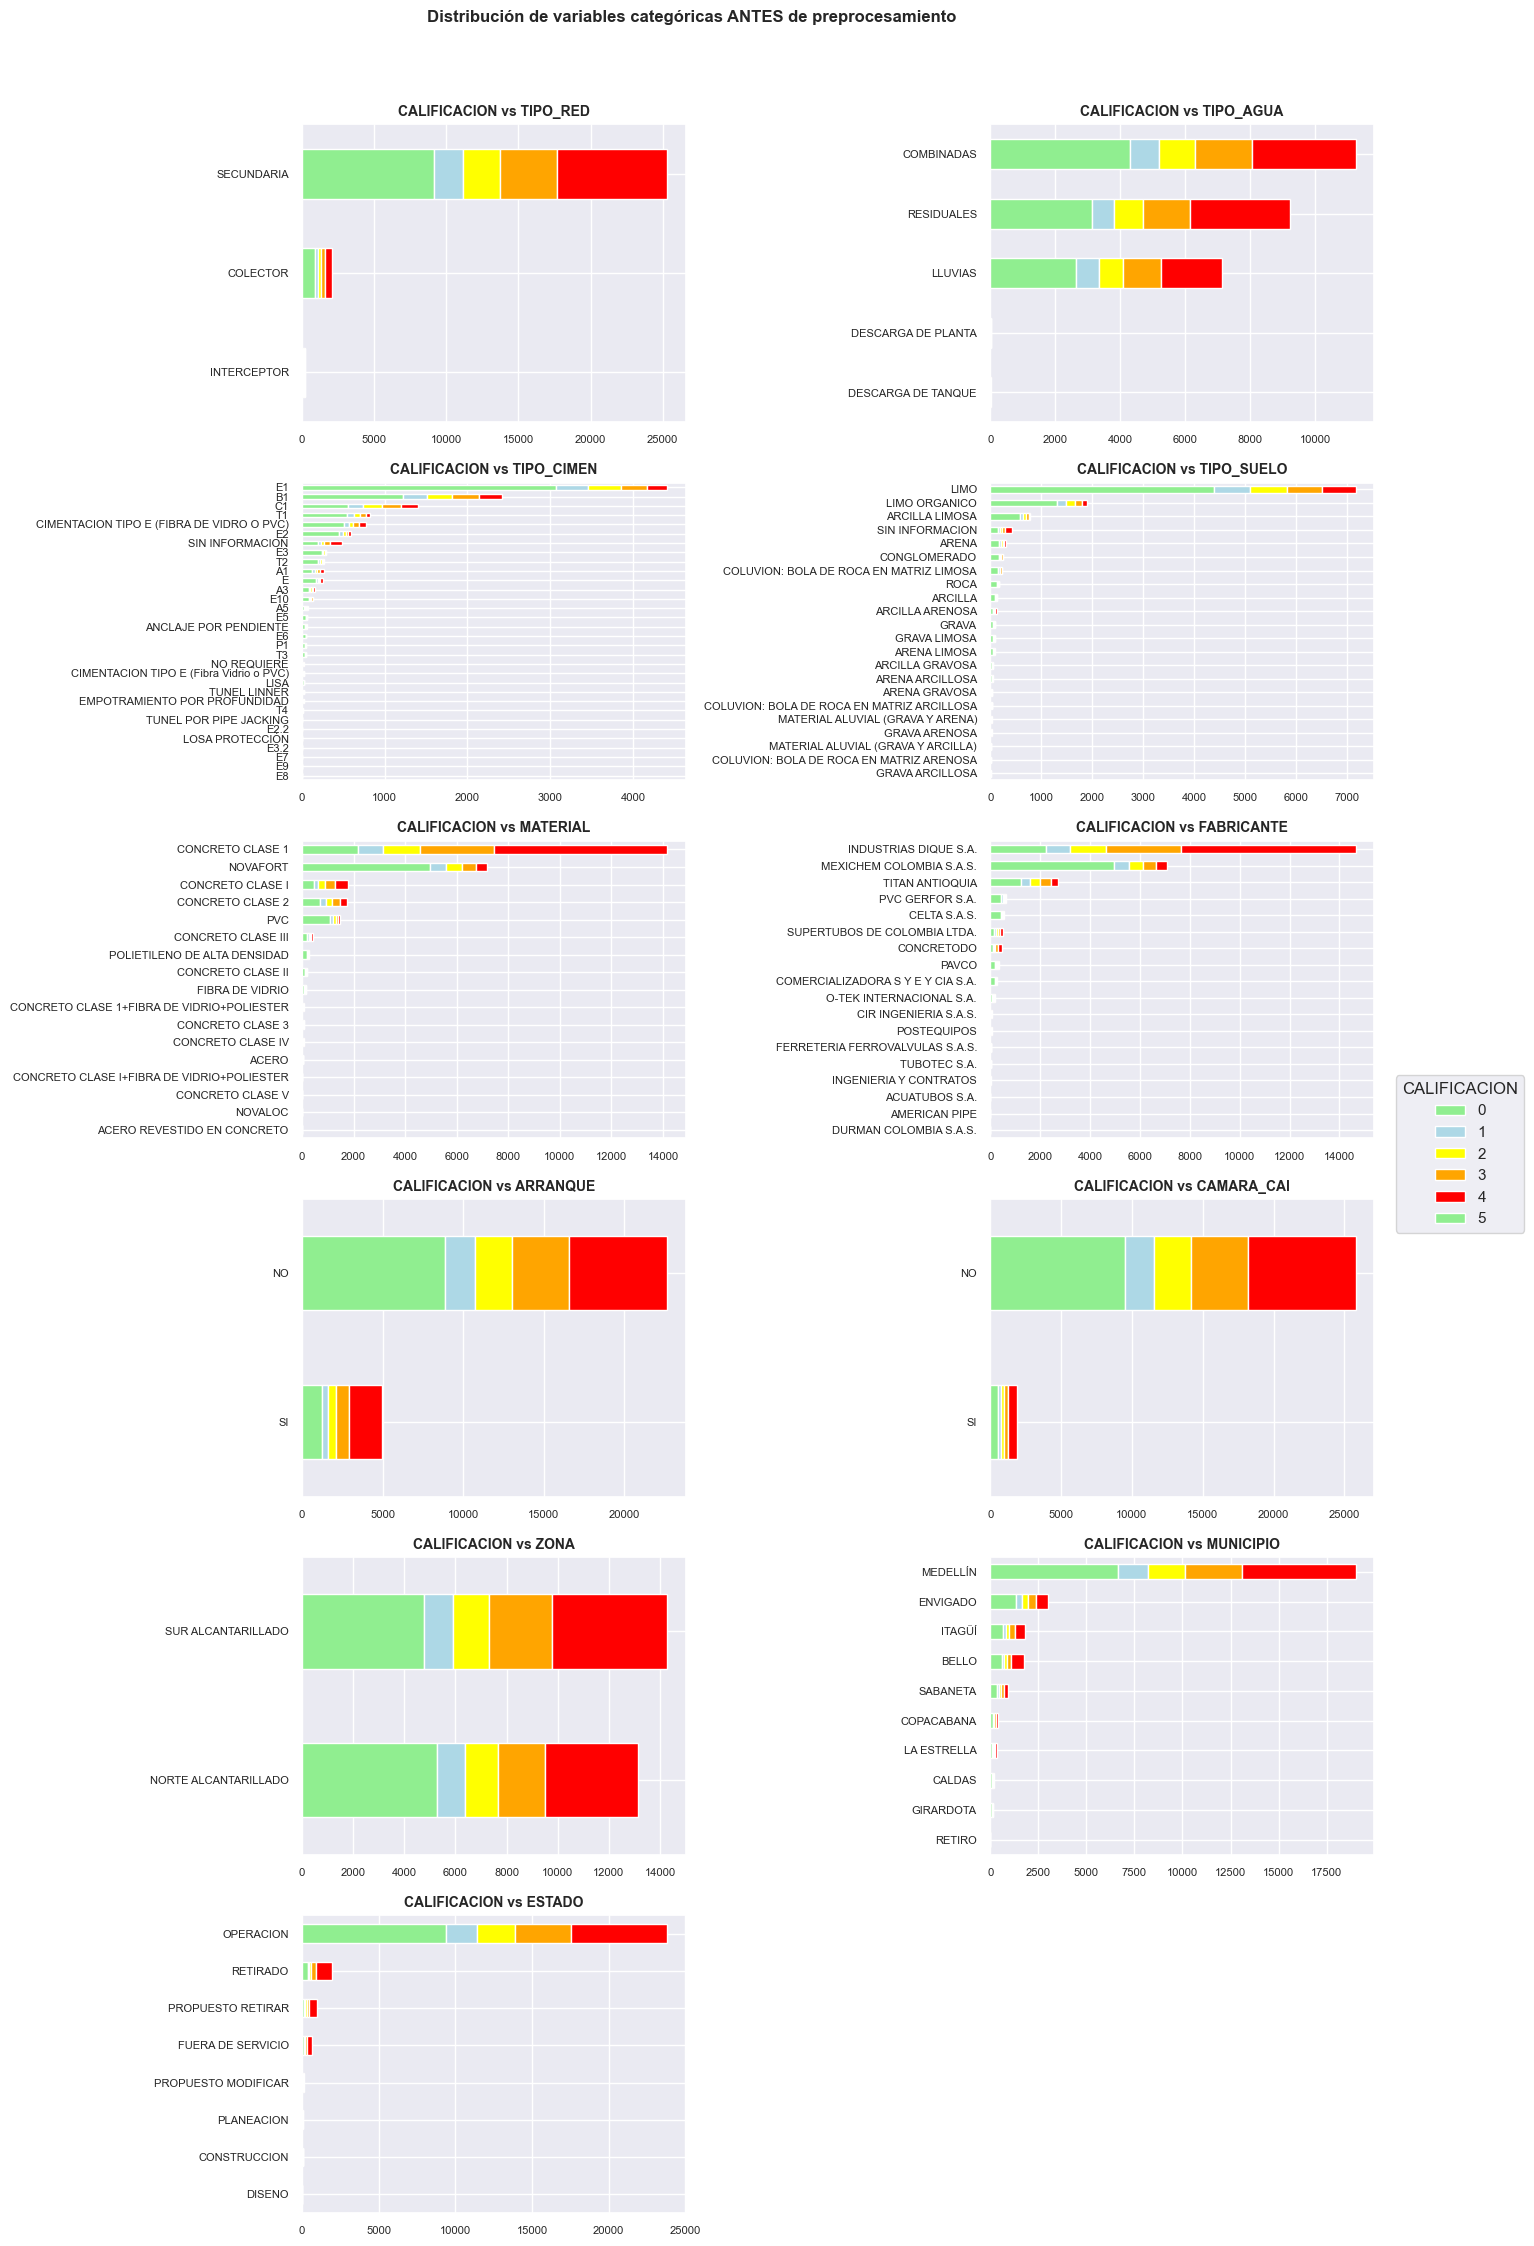

In [11]:
visualizar_distribucion_categoricas(
    categoricas_a_explorar,
    'CALIFICACION',
    df_tramos_calificados,
    titulo='Distribución de variables categóricas ANTES de preprocesamiento'
)

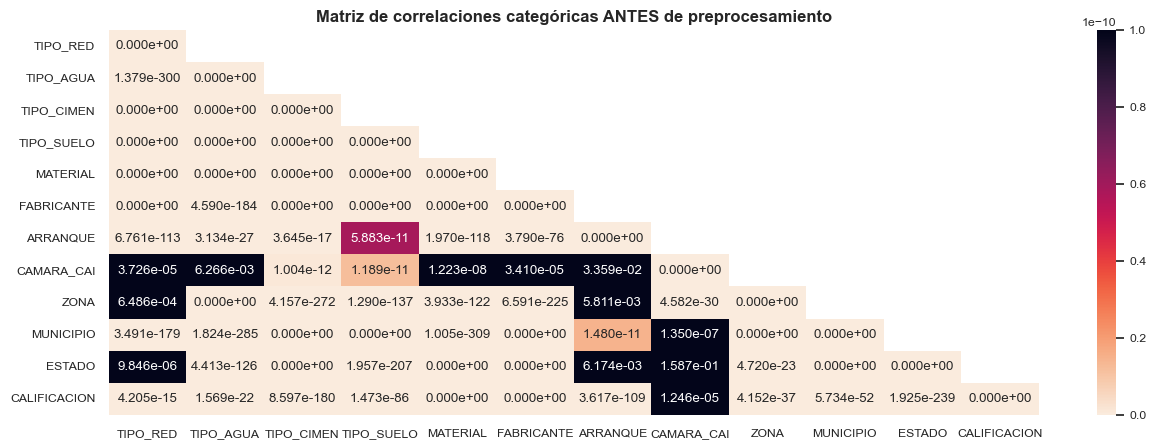

In [12]:
visualizar_correlaciones_categoricas(
    categoricas_a_explorar + ['CALIFICACION'],
    df_tramos_calificados,
    alpha=1e-10,
    titulo=f'Matriz de correlaciones categóricas ANTES de preprocesamiento'
)



---


# Operaciones de preprocesamiento


## Funciones de transformación

In [13]:
%run ../Lib/fn_transformaciones.py

Fecha y Hora de ejecución de módulo: 2024-10-12 09:35:21


## Secuencia de transformaciones

In [14]:
# Aplicar secuencia de operaciones

df_datos_preprocesados = tx_aplicar_transformaciones(df_tramos_calificados)

Aplicando transformación: Depurar datos nulos         ... Terminada.
Aplicando transformación: Convertir tipo de datos     ... Terminada.
Aplicando transformación: Validar rango de datos      ... Terminada.
Aplicando transformación: Unificar unidades a metros  ... Terminada.
Aplicando transformación: Reasignar arranque          ... Terminada.
Aplicando transformación: Reasignar tipo de agua      ... Terminada.
Aplicando transformación: Reasignar materiales        ... Terminada.
Aplicando transformación: Reasignar fabricantes       ... Terminada.
Aplicando transformación: Reasignar zonas             ... Terminada.
Aplicando transformación: Reasignar municipios        ... Terminada.
Aplicando transformación: Reasignar estados           ... Terminada.
Aplicando transformación: Agregar edad de tramos      ... Terminada.
Aplicando transformación: Aregar área de tramos       ... Terminada.
Aplicando transformación: Recalcular pendientes       ... Terminada.
Aplicando transformación: Binariza



---


## Revisión de datos preprocesados

In [15]:
print(df_datos_preprocesados.info())
print('-'*80)
print(df_datos_preprocesados.describe(include='all'))
# print('-'*80)
# print(df_datos_preprocesados.head())
# print('-'*80)

columnas_categoricas = list(df_datos_preprocesados.select_dtypes(include=['object', 'bool']).columns)
columnas_categoricas.remove('DETERIORADO')
columnas_numericas = list(df_datos_preprocesados.select_dtypes(include=['int', 'float']).columns)
# for columna in columnas_categoricas:
#     print('-' * 80)
#     print(columna)
#     print(df_datos_preprocesados[columna].value_counts())

# Encontrar columnas candidatas a binarización
# columnas_binarias = [col for col in columnas_categoricas if df_datos_preprocesados[col].nunique() == 2]
# print('-' * 80)
# print('Columnas categóricas con solamente dos categorias:')
# for col in columnas_binarias:
#     valores = df_datos_preprocesados[col].unique()
#     print(f'{col}: {valores}')

<class 'pandas.core.frame.DataFrame'>
Index: 27471 entries, 0 to 27656
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DETERIORADO         27471 non-null  bool   
 1   EDAD                27471 non-null  float64
 2   DIAMETRO            27471 non-null  float64
 3   LONGITUD            27471 non-null  float64
 4   AREA                27471 non-null  float64
 5   PROF_BATEA          27471 non-null  float64
 6   PROF_BATE1          27471 non-null  float64
 7   PENDIENTE           27471 non-null  float64
 8   TIPO_AGUA           27471 non-null  object 
 9   MATERIAL            27471 non-null  object 
 10  FABRICANTE          27471 non-null  object 
 11  ARRANQUE            27471 non-null  bool   
 12  ZONA_SUR            27471 non-null  bool   
 13  MUNICIPIO_MEDELLIN  27471 non-null  bool   
 14  ESTADO_OPERACION    27471 non-null  bool   
dtypes: bool(5), float64(7), object(3)
memory usage: 2.4+ MB
No

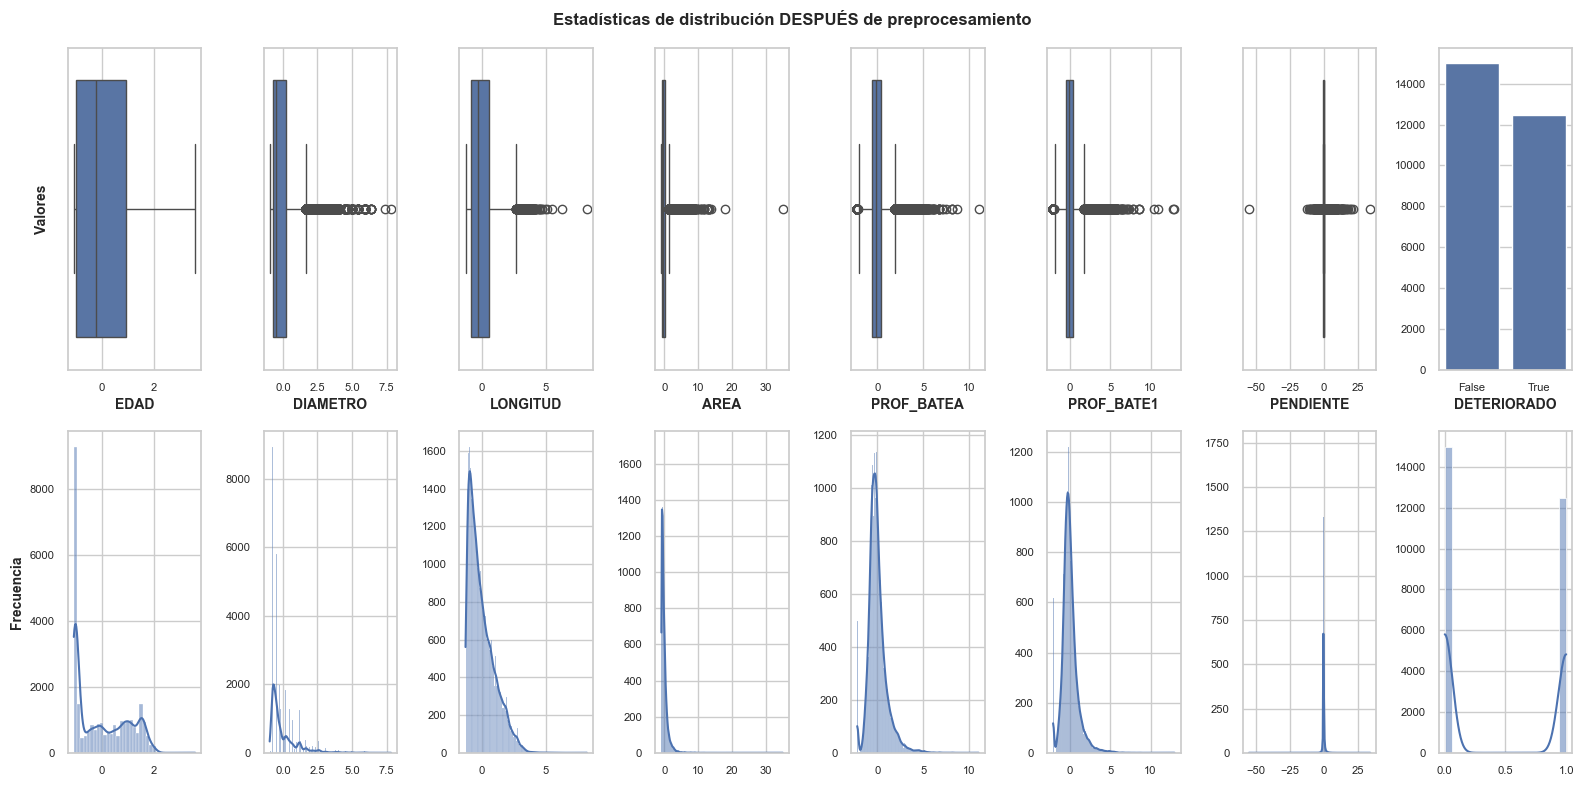

In [16]:
visualizar_distribucion(
    columnas_numericas + ['DETERIORADO'],
    df_datos_preprocesados,
    titulo='Estadísticas de distribución DESPUÉS de preprocesamiento'
)

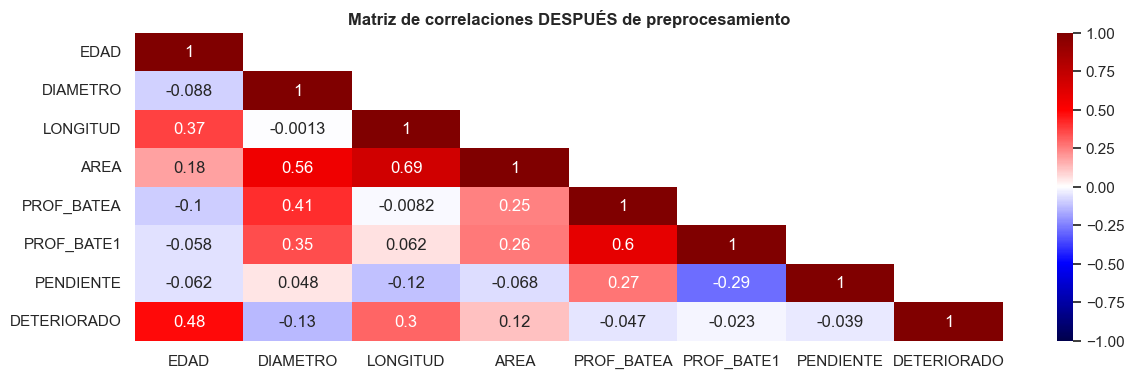

In [17]:
visualizar_correlaciones(
    columnas_numericas + ['DETERIORADO'],
    df_datos_preprocesados,
    titulo='Matriz de correlaciones DESPUÉS de preprocesamiento'
)

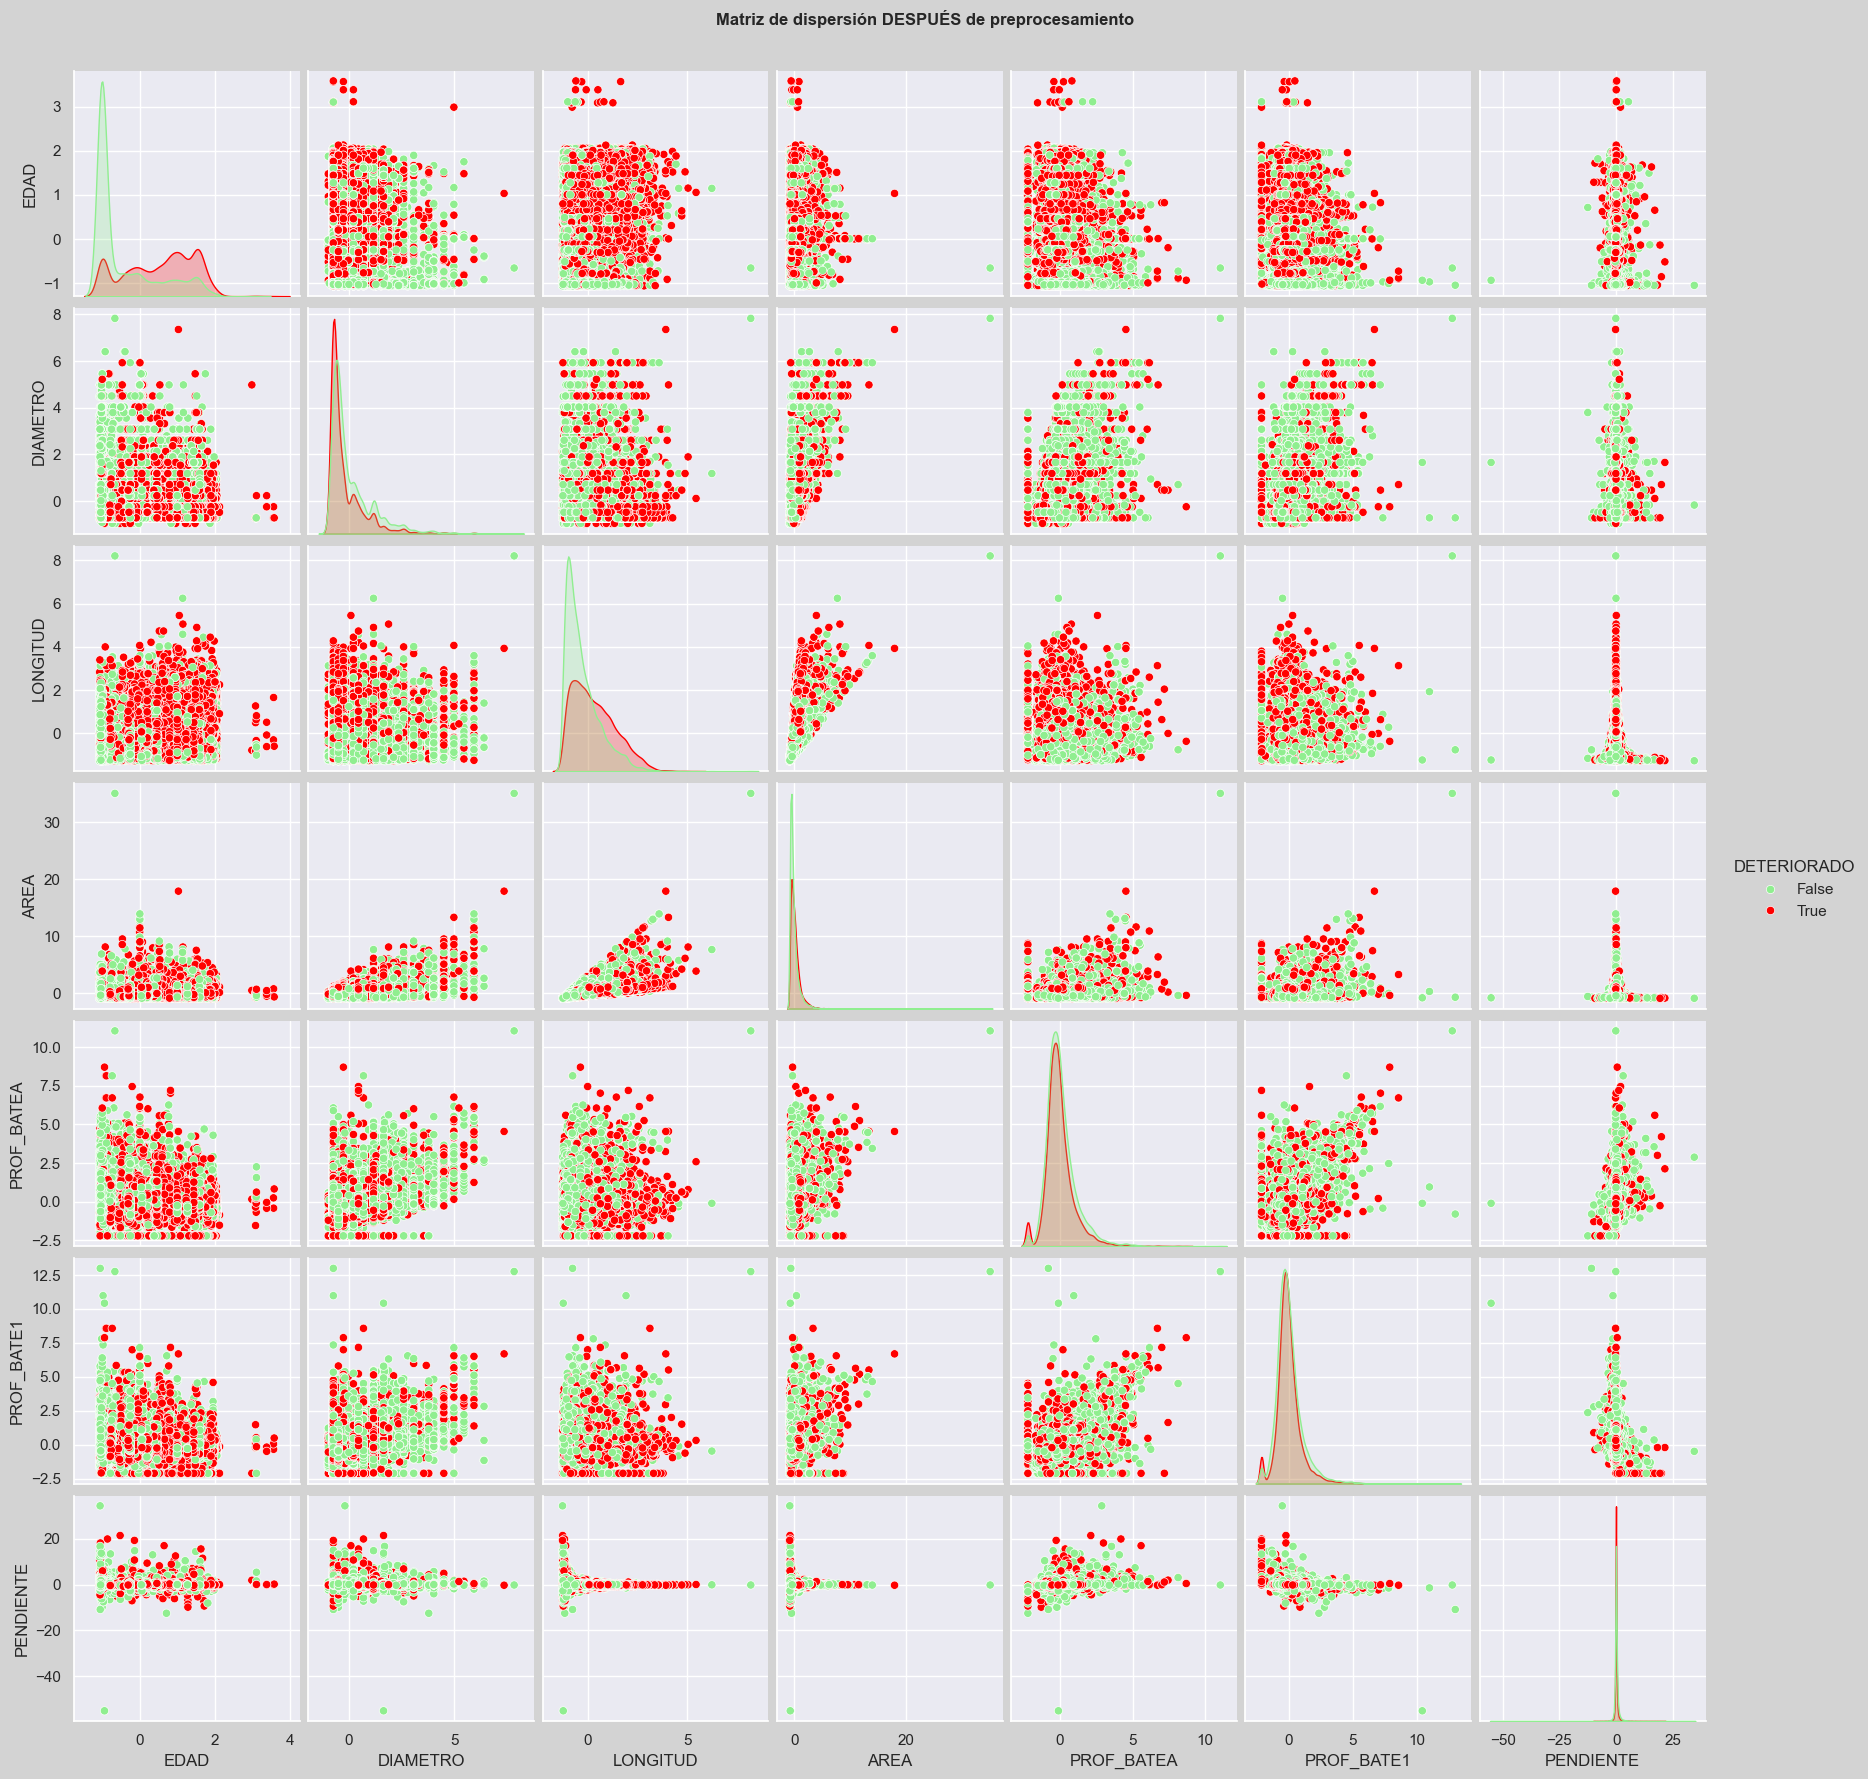

In [18]:
visualizar_matriz_dispersion(
    columnas_numericas,
    df_datos_preprocesados,
    nombre_columna_clasificadora='DETERIORADO',
    titulo='Matriz de dispersión DESPUÉS de preprocesamiento'
)

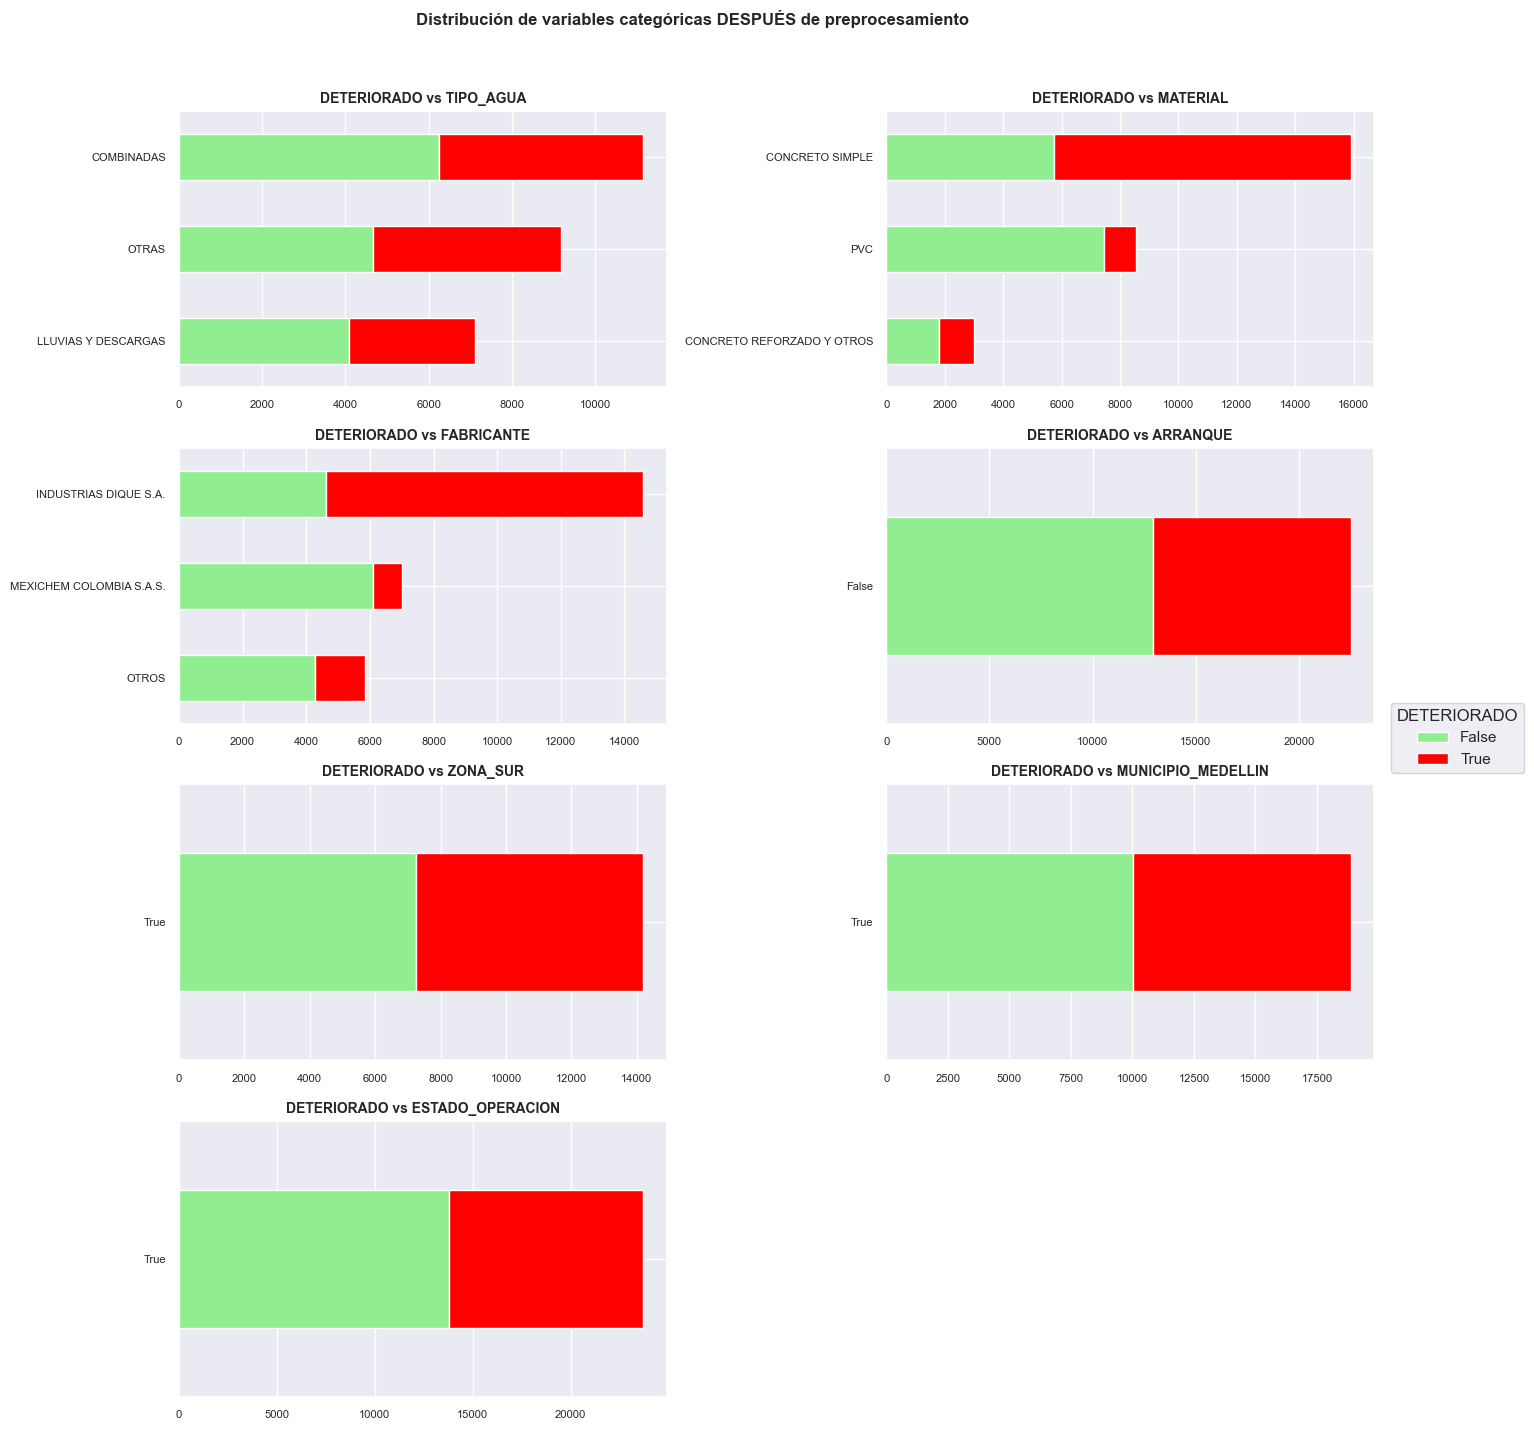

In [19]:
visualizar_distribucion_categoricas(
    columnas_categoricas,
    'DETERIORADO',
    df_datos_preprocesados,
    titulo='Distribución de variables categóricas DESPUÉS de preprocesamiento'
)

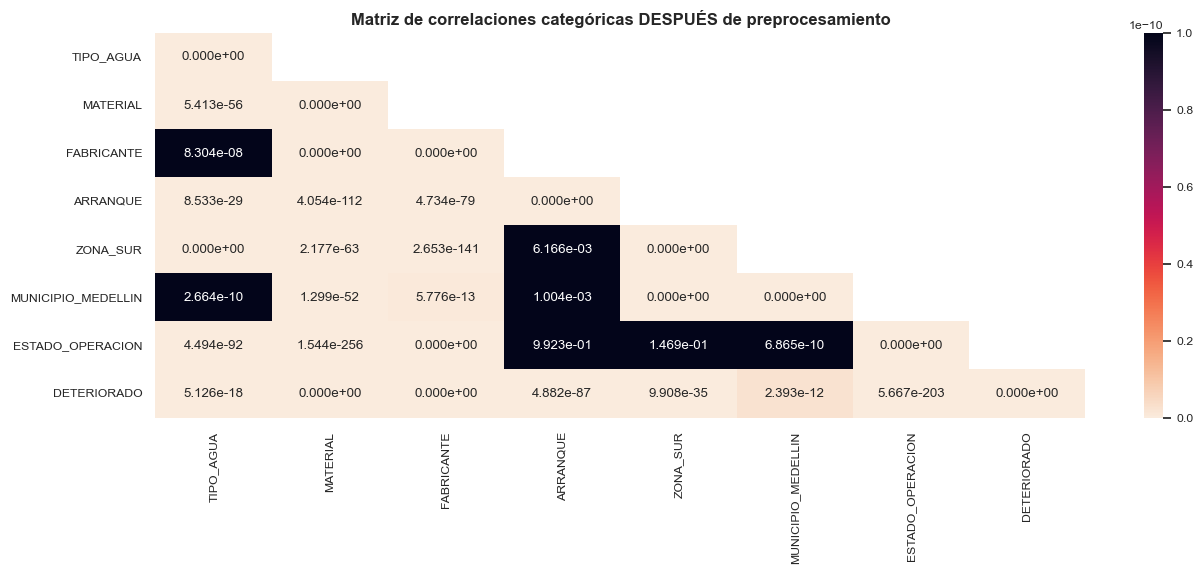

In [20]:
visualizar_correlaciones_categoricas(
    columnas_categoricas + ['DETERIORADO'],
    df_datos_preprocesados,
    alpha=1e-10,
    titulo=f'Matriz de correlaciones categóricas DESPUÉS de preprocesamiento'
)

# Codificación de datos

In [21]:
df_datos_codificados = tx_codificar(df_datos_preprocesados)
print(df_datos_codificados.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27471 entries, 0 to 27656
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DETERIORADO                          27471 non-null  bool   
 1   EDAD                                 27471 non-null  float64
 2   DIAMETRO                             27471 non-null  float64
 3   LONGITUD                             27471 non-null  float64
 4   AREA                                 27471 non-null  float64
 5   PROF_BATEA                           27471 non-null  float64
 6   PROF_BATE1                           27471 non-null  float64
 7   PENDIENTE                            27471 non-null  float64
 8   ARRANQUE                             27471 non-null  bool   
 9   ZONA_SUR                             27471 non-null  bool   
 10  MUNICIPIO_MEDELLIN                   27471 non-null  bool   
 11  ESTADO_OPERACION                 

# Guardar datos preprocesados

In [22]:
archivo_datos_codificados = f'{DIRECTORIO_RESULTADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados.to_csv(archivo_datos_codificados, index=False)
print(f'Guardado {archivo_datos_codificados}')

Guardado ../Resultados/DATOSCODIFICADOS.csv
